# NOTE

- Hi, I am Yuliya, the owner of this project. I wanted to say that thanks for the task, it was fun to implement and play around, I started from zero knowledge in RL, and learned a lot thanks to this. If it is possible, I would gladly appreciate comments and feedback on what I understood/did wrong here! Если же я также вообще примерно все поняла неверно, то тоже было бы классно знать. Thanks again.

Email: yula.barko@gmail.com

# Report

## What difficulties I faced?
- Understanding how the base-RL algorithm should be trained for the task and when can we say that the DQN algorithm is trained enough. Might be because it was my first experience with training RL algorithm.
  - For example, at first I thought about the different state representation (having visual intuition of the dark room, I thought about the 2d array-like presentation). It took time to experiment with this and understand that it is wrong path (for example, more parameters for the state representation - more time to train) and actually doesn't result in the improvement.
  - Достаточно ли длительно я обучала сам DQN на тасках?

- Generating the task sets. I tried to reason what is better: fix the goal position and generate different start positions, vise versa, or generate each time different start positions and goal positions. The last option was not my preference, though it promised the diversity of tasks that we need to get the in-context learning, because I believed I will have troubles training the base RL algorithm that will not learn how to solve the problem.  

  - Проблема также с тем, что разные таски была при таком же обучении трансформера изначально, учитывая то, что был немного исправлен DQN с того момента, и исправление дало лучшее обучение DQN, можно предположить, что ошибка была в этом, но из-за того, что в итоге не было времени на то, что узнать, я решила дать трансформеру последовательность таких заданий, где goal position была фиксированная,
  
  В evaluation я бы посмотрела и посмотреть, сможет ли он справиться с изменненной goal position (на немного)


- Не дошла до того, чтобы сделать evaluation на отложенном test tasks set. :.(

## What I would improve?

### DQN algorithm
1. DarkRoom env that I am using is truncated after the agent did max_steps, for the training of DQN algorithm, I would try to decrease the max_steps parameter after n-episodes.
2.

### Transformer related
- Normalization was skipped (no excuses), would look into that.
- Параметры для тренировки (в основном просто скопированы с данных примеров, но каждый раз при попытке увидеть результат с тренировки трансформера я находила параметры, к-ые возможно в моем случае необходимо изменить, например, в последний день сдачи эттой работы это было target_returns)

### Evaluating if transformer-model has in-context abilities

- after the trained transformer, I would search for another grid-like env (like maze), to see how the model can solve the problem there.


## Conclusion
- In general, I believe, I spent too much time on the training the base-RL algorithm than I should have since I didn't have an experience in RL before,  I wasn't sure that what I am getting is right and I was afraid of one small error on any line that could have completed ruined everything. Because of this, there was little time left for the actual important part.

# Dataset Generation

N individual single task gradient-based Rl algorithms.

1. A task Mᵢ\^{train} is sampled randomly from a task distribution for each RL run.
2. Train the source RL algo (DQN used)
3. Save to the buffer the learning history.
4. Pass saved learning history as the sequence to the Transformer, make it predict next actions.
5. Evaluate the transformer on the test task set, sample the tasks, unroll the transfomer

## Environment set up

As an environment DarkRoom was used. Got from https://github.com/corl-team/toy-meta-gym/blob/main/src/toymeta/dark_room.py

In [ ]:
!pip install toymeta # installs the dependencies

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 32.5 MB/s eta 0:00:00


> **Generating tasks in the set up.**

Different scenarios possible
1. fix the goal position, generate different start positions
2. fix the start position, generate different goal positions
3. generate different start and goal positions.

In the code above I follow first scenario.

[Note when I already finished up?]However, I should note, that I might not get to the in-context learning, I assume that the dataset of tasks that I created might not be either big enough, or different one. In the beginning, when I approached the task, I focused too much on making DQN to work and trying to understand, whether it was successfull or not.

Note: reset() method defined in the env start the agent in the center position, since I am usually having a task set, then we need to get the start position from it, while goal stays the same.

In [ ]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces


def all_goals(grid_size):
    goals = np.mgrid[0:grid_size, 0:grid_size].reshape(2, -1).T
    return goals


class DarkRoom(gym.Env):
    metadata = {"render_modes": ["rgb_array"], "render_fps": 1}

    def __init__(self, size=9, goal=None, random_start=True, terminate_on_goal=False, max_steps=1000, render_mode="rgb_array"):
        self.size = size
        self.agent_pos = None

        if goal is not None:
            self.goal_pos = np.asarray(goal)
            assert self.goal_pos.ndim == 1
        else:
            self.goal_pos = self.generate_goal()

        self.observation_space = spaces.Discrete(self.size**2)
        self.action_space = spaces.Discrete(5)

        self.action_to_direction = {
            0: np.array((0, 0), dtype=np.float32),  # noop
            1: np.array((-1, 0), dtype=np.float32),  # up
            2: np.array((0, 1), dtype=np.float32),  # right
            3: np.array((1, 0), dtype=np.float32),  # down
            4: np.array((0, -1), dtype=np.float32),  # left
        }
        self.center_pos = (self.size // 2, self.size // 2)
        self.terminate_on_goal = terminate_on_goal
        self.render_mode = render_mode
        self.random_start = random_start
        self.current_step = 0
        self.max_steps = max_steps

    def generate_pos(self):
        return self.np_random.integers(0, self.size, size=2).astype(np.float32)

    def generate_goal(self):
        return self.np_random.integers(0, self.size, size=2)

    def pos_to_state(self, pos):
        return int(pos[0] * self.size + pos[1])

    def state_to_pos(self, state):
        return np.array(divmod(state, self.size))

    def reset_from_set(self, tasks_set, seed=42): # resets the state by choosing the start and goal positions that can be introduced by agent
        index = self.np_random.integers(0, len(tasks_set))
        self.agent_pos = np.ndarray.tolist(tasks_set[index][0])
        self.goal_pos = tasks_set[index][1]
        return self.pos_to_state(self.agent_pos), {}


    def reset(self, seed=None, options=None):
        super().reset(seed=seed, options=options)
        if self.random_start:
            self.agent_pos = self.generate_pos()
        else:
            self.agent_pos = np.array(self.center_pos, dtype=np.float32)
        self.current_step = 0
        return self.pos_to_state(self.agent_pos), {}

    def step(self, action):
        """need the method to return s_next, r, terminated, truncated, _  """
        self.current_step += 1
        self.agent_pos = np.clip(self.agent_pos + self.action_to_direction[action], 0, self.size - 1)

        reward = 1.0 if np.array_equal(self.agent_pos, self.goal_pos) else 0.0
        terminated = True if reward and self.terminate_on_goal else False
        truncated = self.current_step >= self.max_steps

        return self.pos_to_state(self.agent_pos), reward, terminated, truncated, {}

    def render(self):
        if self.render_mode == "rgb_array":
            # Create a grid representing the dark room
            grid = np.full((self.size, self.size, 3), fill_value=(255, 255, 255), dtype=np.uint8)
            grid[self.goal_pos[0], self.goal_pos[1]] = (255, 0, 0)
            grid[int(self.agent_pos[0]), int(self.agent_pos[1])] = (0, 255, 0)
            return grid

    def generate_tasks(self, num_tasks):
        """We want to train the agent to navigate to a specific goal from various starting points """
        tasks = []
        goal_state = self.generate_goal()
        for _ in range(num_tasks):
          start_state = self.generate_pos() # to be consistent with the environment?
          tasks.append((start_state, goal_state))
        return tasks


Discrete(5) Discrete(81)
[4 4] 40


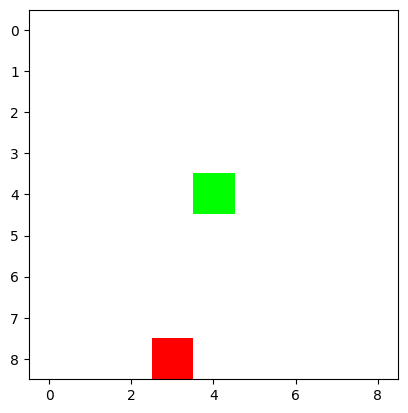

In [ ]:
env = DarkRoom(size = 9, goal=None, random_start=False, terminate_on_goal=False)
print(env.action_space, env.observation_space)
s, _  = env.reset()

print(env.state_to_pos(s), s)
import matplotlib.pyplot as plt
env.render_mode ="rgb_array"

plt.imshow(env.render())


How many tasks do we want to generate?
If the episodes for DarkRoom env is 1000, should we do 1000?

The maximum possible unique combinations for DarkRoom 9x9 is 81x81?


## Things to explore:
- can convolutional neural nets be better? But for this the preprocess_state will need to pass the 2d grid.
- different ways to generate tasks for DarkRoom(fix one position, generate the other, or generate both of them)
- added the parameter to truncate the env: ***the max number of steps***, could experiment with making the parameter more/less.



## Generating Dataset

### DQN

Let's use DQN as RL algorithm to solve the problem. Thanks to AIRI summer 2023's seminar, the implementation is clear.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DQN(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(DQN, self).__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_dims[0]))

        for i in range(1, len(hidden_dims)):
            self.layers.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))

        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, x):
        if len(x.shape) != 2:
          x = x.reshape(-1, 1)
        for layer in self.layers:
            x = F.tanh(layer(x))

        return self.output_layer(x)



In [ ]:
def to_tensor(x, dtype=np.float32):
    if isinstance(x, torch.Tensor):
        return x
    x = np.asarray(x, dtype=dtype)
    x = torch.from_numpy(x)
    return x

def select_action_eps_greedy(Q, state, epsilon):
    """ Changed how the states is passed to it, and added the to_tensor method."""
    if not isinstance(state, torch.Tensor):
        state = to_tensor(state)

    with torch.no_grad():
      Q_s = Q(state).detach().numpy()

    if np.random.random() < epsilon:
      n_actions = Q_s.shape[-1]
      action = np.random.choice(n_actions)
    else:
      action = np.argmax(Q_s)

    action = int(action)
    return action

In [ ]:
def eval_dqn(env, Q, render=False, test_task_set=None,):
    """Оценка качества работы алгоритма на одном эпизоде"""
    if not test_task_set:
      tasks = 1
    else:
      tasks = len(test_task_set)

    total_reward = 0

    for t_ind in range(tasks):
      print("eval task", t_ind)
      if (tasks== 1):
        s, _ = env.reset()
      else:
        env.agent_pos = test_task_set[t_ind][0]
        s = env.pos_to_state(test_task_set[t_ind][0])
        env.goal_pos =  test_task_set[t_ind][1]
      print(f"\tStart:current_pos: {env.agent_pos}, and goal: {env.goal_pos}")

      done, ep_return = False, 0.
      actions = []
      while not done:
          a = select_action_eps_greedy(Q, s, epsilon=0.)
          actions.append(a)
          s_next, r, terminated, truncated, _ = env.step(a)
          done = terminated or truncated
          ep_return += r
          s = s_next

          if done:
              break
      total_reward += ep_return
    return ep_return

In [ ]:
def to_tensor(x, dtype=np.float32):
    if isinstance(x, torch.Tensor):
        return x
    x = np.asarray(x, dtype=dtype)
    x = torch.from_numpy(x)
    return x

def compute_td_loss(
        Q, states, actions, rewards, next_states, terminateds,
        gamma=0.99, check_shapes=False, regularizer=.1
):
    s = to_tensor(states)                     # shape: [batch_size, state_size]
    a = to_tensor(actions, int).long()        # shape: [batch_size]
    r = to_tensor(rewards)                    # shape: [batch_size]
    s_next = to_tensor(next_states)           # shape: [batch_size, state_size]
    term = to_tensor(terminateds, bool)       # shape: [batch_size]

    Q_s_a = torch.gather(Q(s), dim=1, index=torch.unsqueeze(a, 1)).squeeze(-1)

    with torch.no_grad():
      Q_sn = Q(s_next)
      V_sn, _ = torch.max(Q_sn, axis=-1)

    target = r + gamma * V_sn  * torch.logical_not(term)
    td_error = Q_s_a - target
    loss = torch.mean(td_error ** 2)
    loss += regularizer * Q_s_a.mean()

    return loss

In [ ]:
def sample_batch(replay_buffer, n_samples):
    # sample randomly `n_samples` samples from replay buffer
    # and split an array of samples into arrays: states, actions, rewards, next_actions, terminateds
    n_samples = min(len(replay_buffer), n_samples)
    indices = np.random.choice(len(replay_buffer), n_samples, replace=False)

    states, actions, rewards, next_actions, terminateds = [], [], [], [], []
    for i in indices:
      si, ai, ri, s_nexti, termi = replay_buffer[i]
      states.append(si)
      actions.append(ai)
      rewards.append(ri)
      next_actions.append(s_nexti)
      terminateds.append(termi)

    return np.array(states), np.array(actions), np.array(rewards), np.array(next_actions), np.array(terminateds)

In [ ]:
def sample_n_tasks(tasks_set, n = 1):
  sampled_ind = np.random.choice(len(tasks_set), n, replace=True)
  sampled = [tasks_set[ind] for ind in sampled_ind]
  return sampled

wiht replay_buffer_size = 400 -> last total reward 670 (with smooth_ret_window=4?)
replay_buffer_sie =

### Evn with terminate_on_goal=True + target_Q



In [ ]:
def to_tensor(x, dtype=np.float32):
    if isinstance(x, torch.Tensor):
        return x
    x = np.asarray(x, dtype=dtype)
    x = torch.from_numpy(x)
    return x

def compute_td_loss(
        Q, target_Q, states, actions, rewards, next_states, terminateds,
        gamma=0.99, check_shapes=False, regularizer=.08
):
    s = to_tensor(states).reshape(-1,1)                     # shape: [batch_size, state_size]
    a = to_tensor(actions, int).long()        # shape: [batch_size]
    r = to_tensor(rewards)                    # shape: [batch_size]
    s_next = to_tensor(next_states)           # shape: [batch_size, state_size]
    term = to_tensor(terminateds, bool)       # shape: [batch_size]

    Q_s_a = torch.gather(Q(s), dim=1, index=torch.unsqueeze(a, 1)).squeeze(-1)
    with torch.no_grad():
      Q_sn = target_Q(s_next)
      V_sn, _ = torch.max(Q_sn, axis=-1)

    target = r + gamma * V_sn  * torch.logical_not(term)
    td_error = Q_s_a - target

    loss = torch.mean(td_error ** 2)
    loss += regularizer * torch.abs(Q_s_a.mean())

    return loss

- if we want while not done, then there will be 1000 number of episodes, but also we don't want to jump on the other scenario as described:

 if done:
               sampled_task = sample_n_tasks(train_task_set) # env.reset() was changed on sampled_tasks
               s, env.agent_pos, env.goal_pos = env.pos_to_state(sampled_task[0][0]), sampled_task[0][0], sampled_task[0][1]
               s = preprocess_state(s, input_dim) # want [1, 81] or [81]?
               done = False
    

In [ ]:
from collections import deque

def linear(st, end, duration, t):
    if t >= duration:
        return end
    return st + (end - st) * (t / duration)

def run_rb_dqn_multiple_episodes(
        env,
        Q,
        target_Q,
        opt,
        num_episodes=100, # 1000
        train_task_set=None,
        hidden_dims=(256, 256),
        update_target_steps=10000, # Parameter used for updating the Q_target
        regularizer=0.1,
        lr=1e-3,
        total_max_steps=10000,
        replay_buffer_size=20000, # could be changed. it is recommended 10000 - 100000???. was 400.
        eps_st=.4, eps_end=.02, eps_dur=.5,

        train_schedule=4, # Empirically was said to be good

        batch_size=32,
        eval_schedule=10000,
        smooth_ret_window=10,
        success_ret=150. #should be changed according to the darkroom(was200)? I think that it should be when it reached the target and stayed there, so it is +1 reward for 100 episodes aka sliding window
        # smooth_ret_window was 5
):
    render = False
    # saving the learning history for the transformer, but better rename state_sequence, also according to the defined load_d4rl_trajectories from *TODO github page*
    learning_history = {
        'observations': [],
        'actions': [],
        'rewards': [],
        'terminals':[],
        'timeouts':[],
        # 'rewards_to_go': [], will be calculated in load4rltraj
        "time_steps":[],
        # 'next_state': [],
    }

    # input_dim = 1
    gamma = 1.0
    global_step = 0 # Counts the steps

    # Data used in plots:
    total_reward_per_episode = []
    # avg_return_per_episode = [] # evaluation rewards actually?
    # returns_to_go = []  # Initialize list to store returns-to-go
    losses_per_episode = [] # should we average it along the episode?
    epsilons_per_episode = [] # should we average it along the episodes?


    for episode in range(num_episodes):
      print(f"Episode {episode}")
      eval_return_history = deque(maxlen=smooth_ret_window)
      replay_buffer = deque(maxlen=replay_buffer_size)

      sampled_task = sample_n_tasks(train_task_set) # env.reset() was changed on sampled_tasks
      s, env.agent_pos, env.goal_pos = env.pos_to_state(sampled_task[0][0]), sampled_task[0][0], sampled_task[0][1]
      env.current_step = 0
      # s = preprocess_state(s, input_dim) # want [1, 81] or [81]?
      done = False

      # information used to plot the training process
      total_reward = 0
      episode_rewards = [] # to calculate the returns-to-go
      losses = []
      epsilons = []
      avg_returns = []

      # information for the transformer
      states_for_episodes = []
      actions_for_episodes = []
      rewards_for_episodes = []
      time_steps_for_episode = []
      terminals_per_episode = []
      timeouts_per_episode = []
      # n_states_for_episodes = [] # TODO also don't need for transformer


      #rendering
      if render:
        frame = env.render()
        plt.imshow(frame)
        plt.title(f"Episode:{episode} ")
        plt.show()

      while not done:
          epsilon = linear(eps_st, eps_end, eps_dur * total_max_steps, global_step)
          epsilons.append(epsilon)
          a = select_action_eps_greedy(Q, [s], epsilon=epsilon)
          s_next, r, terminated, truncated, _ = env.step(a)
          global_step+= 1

          # s_next = preprocess_state(s_next, input_dim) # TODO comment & train
          done = terminated or truncated

          states_for_episodes.append(s)

          if a >= 5:
            raise ValueError("a value is bigger than it should")

          actions_for_episodes.append(a)
          rewards_for_episodes.append(r)
          time_steps_for_episode.append(global_step)
          terminals_per_episode.append(terminated)
          timeouts_per_episode.append(truncated)

          replay_buffer.append((s, a, r, s_next, terminated))

          if global_step % train_schedule == 0 and len(replay_buffer) > batch_size:
              train_batch = sample_batch(replay_buffer, batch_size)
              states, actions, rewards, next_states, terminateds = train_batch
              opt.zero_grad()
              loss = compute_td_loss(Q, target_Q, states, actions, rewards, next_states, terminateds, regularizer=regularizer)
              loss.backward()
              opt.step()

              losses.append(loss.item())

          if global_step % update_target_steps == 0:
              print("on the update_target step, loss is ", loss)
              target_Q.load_state_dict(Q.state_dict())

          if global_step % eval_schedule == 0:
              test_task_set = sample_n_tasks(train_task_set, 2)# ??
              eval_return = eval_dqn(env, Q, render=False, test_task_set=test_task_set) # Note: target_Q is not used in evaluation process
              eval_return_history.append(eval_return)
              avg_return = np.mean(eval_return_history)
              print(f'{global_step=} | {avg_return=:.3f} | {epsilon=:.3f}')

              # if avg_return >= success_ret:
              #     print('Решено!')
              #     break

          s = s_next
          total_reward += r
          episode_rewards.append(r)

      epsilons_per_episode.append(np.mean(epsilons))
      total_reward_per_episode.append(total_reward)
      losses_per_episode.append(np.mean(losses))

      # for the transformer we save information across episodes
      learning_history['observations'].append(np.array(states_for_episodes, dtype=np.float32))# should we append the states that was preprocessed? I think yes.
      learning_history['actions'].append(np.array(actions_for_episodes,dtype=np.float32))
      learning_history['rewards'].append(np.array(rewards_for_episodes, dtype=np.float32))
      learning_history['time_steps'].append(np.array(time_steps_for_episode, dtype=np.float32))
      learning_history['terminals'].append(np.array(terminals_per_episode, dtype=np.float32))
      learning_history['timeouts'].append(np.array(timeouts_per_episode, dtype=np.float32))

    return Q, learning_history, (total_reward_per_episode,
                                 losses_per_episode,
                                 epsilons_per_episode)

#### Creation of the env and training the dqn

Creating the task set where 100 tasks (81 if no repetitions are good) have the same goal, but different starting positions 50 times => 50*100 = 5000 tasks.

In [ ]:
def split_tasks(tasks, seed=42):
  np.random.shuffle(tasks)
  b = int(len(tasks)*0.9)
  train_array = tasks[:b]
  test_array = tasks[b:]
  return train_array, test_array

In [ ]:
INPUT_DIM = 1
HIDDEN_DIMS = (128, 256, 512, 512, 256, 128)
LR = 0.05
MAX_STEPS_ENV= 200
REGULARIZER=0.75 #0.75 in article for DQN watermaze
update_target_step_arr = [3000] #, 5000, 7000, 9000]
update_target_step = 3000
eps_total_max_steps_arr = [60000] #, 70000, 90000]
eps_total_max_steps = 60000
# save_train_tasks(train_tasks)
# save_test_tasks(test_tasks)
hidden_dims = (128, 256, 512, 512, 256, 128)

overall_test_tasks_set = []
overall_train_tasks_set = []
overall_task_set = []

In [ ]:
import matplotlib.pyplot as plt

results_across_trainings = {
    'steps': [],
    'update_target_steps': [],
    'regularizers': [],
    'lrs':[],
    'epsilons':[],
    'total_max_steps':[],
    'total_rewards': [],
    'losses': []
}

Q = DQN(
    input_dim=INPUT_DIM, hidden_dims=HIDDEN_DIMS, output_dim=env.action_space.n
)
target_Q = DQN(
        input_dim=INPUT_DIM, hidden_dims=HIDDEN_DIMS, output_dim=env.action_space.n
    )
opt = torch.optim.Adam(Q.parameters(), lr=LR)
env = DarkRoom(size = 9, goal=None, random_start=False, terminate_on_goal=True, max_steps=MAX_STEPS_ENV) # try 400
env.observation_space.n = 1
s, _  = env.reset()

for j in range(1):
  overall_task_set.extend(env.generate_tasks(100))

train_tasks, test_tasks = split_tasks(overall_task_set)

In [ ]:



trainedQ, learning_history, results = run_rb_dqn_multiple_episodes(Q = Q,
                                                                  target_Q = target_Q,
                                                                  opt = opt,
                                                                  env=env,
                                                                  num_episodes=500,
                                                                  train_task_set=train_tasks,
                                                                  update_target_steps=update_target_step,
                                                                  regularizer=REGULARIZER,
                                                                  lr=LR,
                                                                  total_max_steps=eps_total_max_steps,
                                                                  replay_buffer_size=20000, # could be changed. it is recommended 10000 - 100000???. was 400.
                                                                  )
total_reward_per_episode,  losses_per_episode, epsilons_per_episode = results

print(epsilons_per_episode)
results_across_trainings['steps'].append(MAX_STEPS_ENV)
results_across_trainings['update_target_steps'].append(update_target_step)
results_across_trainings['regularizers'].append(REGULARIZER)
results_across_trainings['lrs'].append(LR)
results_across_trainings['epsilons'].append(epsilons_per_episode)
results_across_trainings['total_rewards'].append(total_reward_per_episode)
results_across_trainings['losses'].append(losses_per_episode)
results_across_trainings['total_max_steps'].append(eps_total_max_steps)





Episode 0
Episode 1
Episode 2
Episode 3
Episode 4
Episode 5
Episode 6
Episode 7
Episode 8
Episode 9
Episode 10
Episode 11
Episode 12
Episode 13
Episode 14
Episode 15
Episode 16
Episode 17
Episode 18
Episode 19
Episode 20
on the update_target step, loss is  tensor(0.1707, grad_fn=<AddBackward0>)
Episode 21
Episode 22
Episode 23
Episode 24
Episode 25
Episode 26
Episode 27
Episode 28
Episode 29
Episode 30
Episode 31
Episode 32
Episode 33
Episode 34
Episode 35
Episode 36
Episode 37
Episode 38
Episode 39
on the update_target step, loss is  tensor(0.2699, grad_fn=<AddBackward0>)
Episode 40
Episode 41
Episode 42
Episode 43
Episode 44
Episode 45
Episode 46
Episode 47
Episode 48
Episode 49
Episode 50
Episode 51
Episode 52
Episode 53
Episode 54
Episode 55
Episode 56
Episode 57
Episode 58
Episode 59
Episode 60
on the update_target step, loss is  tensor(1.0912, grad_fn=<AddBackward0>)
Episode 61
Episode 62
Episode 63
Episode 64
Episode 65
eval task 0
	Start:current_pos: [4. 1.], and goal: [4 4]
ev

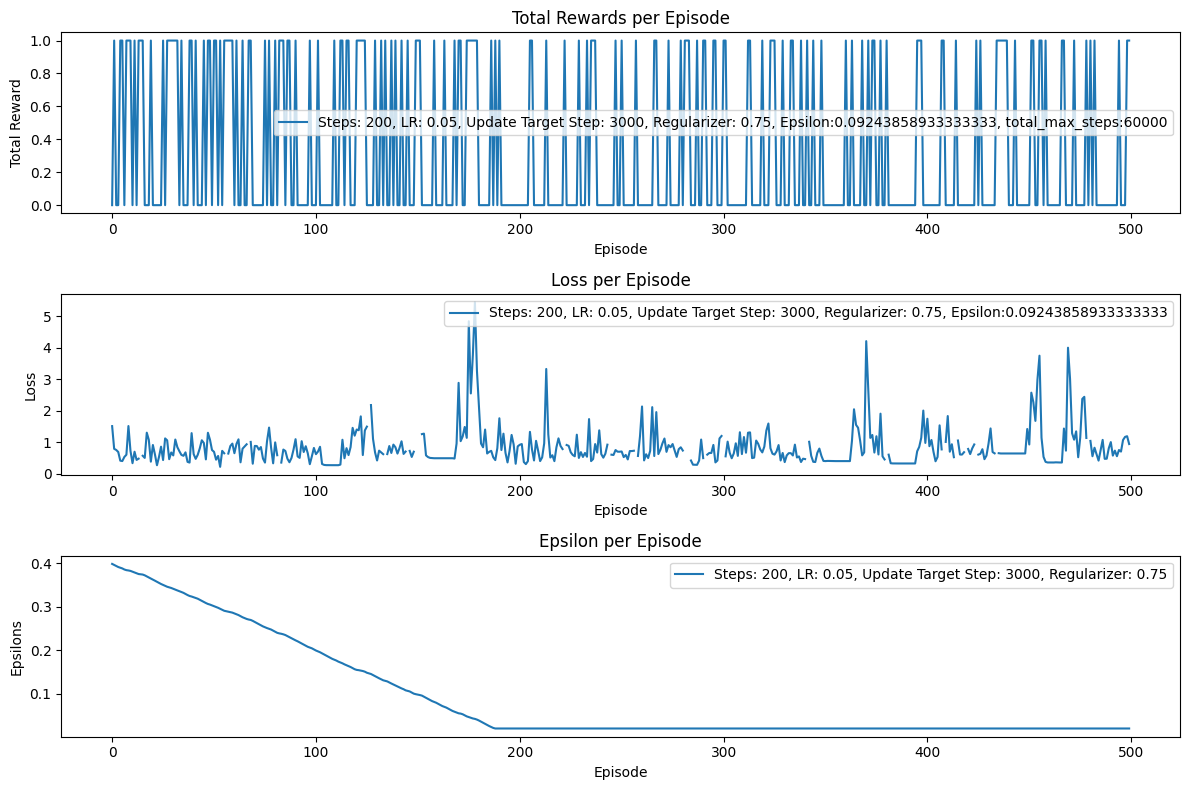

In [ ]:
results = results_across_trainings


for i in range(len(results['steps'])):
    step = results['steps'][i]
    update_target_step = results['update_target_steps'][i]
    regularizer = results['regularizers'][i]
    epsilon = results['epsilons'][i]
    lrs = results['lrs'][i]
    total_rewards = results['total_rewards'][i]
    losses = results['losses'][i]
    total_max_steps = results['total_max_steps'][i]

    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(total_rewards, label=f"Steps: {step}, LR: {lrs}, Update Target Step: {update_target_step}, Regularizer: {regularizer}, Epsilon:{np.mean(epsilon)}, total_max_steps:{total_max_steps}")
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Rewards per Episode')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(losses, label=f"Steps: {step}, LR: {lrs}, Update Target Step: {update_target_step}, Regularizer: {regularizer}, Epsilon:{np.mean(epsilon)}")
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.title('Loss per Episode')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(epsilon, label=f"Steps: {step}, LR: {lrs}, Update Target Step: {update_target_step}, Regularizer: {regularizer}")
    plt.xlabel('Episode')
    plt.ylabel('Epsilons')
    plt.title('Epsilon per Episode')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
learning_history.keys(), len(learning_history['actions'][0])

(dict_keys(['observations', 'actions', 'rewards', 'terminals', 'timeouts', 'time_steps']),
 200)

In [ ]:
# save
from google.colab import drive
drive.mount('/content/drive')
model_save_path = '/content/drive/My Drive/AIRI/dqn_model.pth'

torch.save(trainedQ.state_dict(), model_save_path)

# save learning history

Mounted at /content/drive


#### optionally save the learning_history

In [ ]:
with open('observations.txt', 'w') as f:
      for el in learning_history['observations']:
          # first is start, second is goal!
          np.savetxt(f, el, delimiter=',',)
          f.write('\n')
with open('actions.txt', 'w') as f:
      for el in learning_history['actions']:
          # first is start, second is goal!
          np.savetxt(f, el, delimiter=',',)
          f.write('\n')
with open('rewards.txt', 'w') as f:
      for el in learning_history['rewards']:
          # first is start, second is goal!
          np.savetxt(f, el, delimiter=',',)
          f.write('\n')
with open('terminals.txt', 'w') as f:
      for el in learning_history['terminals']:
          # first is start, second is goal!
          np.savetxt(f, el, delimiter=',',)
          f.write('\n')
with open('timeouts.txt', 'w') as f:
      for el in learning_history['timeouts']:
          # first is start, second is goal!
          np.savetxt(f, el, delimiter=',',)
          f.write('\n')

In [ ]:
def save_train_tasks(train_tasks):
  with open('train_task_set.txt', 'w') as f:
      for el in train_tasks:
          # first is start, second is goal!
          np.savetxt(f, el, delimiter=',', fmt='%.4f')
          f.write('\n')

def save_test_tasks(test_tasks):
  with open('test_task_set.txt', 'w') as f:
      for el in test_tasks:
          # first is start, second is goal!
          np.savetxt(f, el, delimiter=',', fmt='%.4f')
          f.write('\n')

In [ ]:
save_train_tasks(train_tasks)
save_test_tasks(test_tasks)

## Algorithm Distillation

Credits to : https://github.com/corl-team/headless-ad/tree/main

In [ ]:
# inspiration:
# 1. https://github.com/kzl/decision-transformer/blob/master/gym/decision_transformer/models/decision_transformer.py
# 2. https://github.com/karpathy/minGPT
import os
import random
import uuid
from collections import defaultdict
from dataclasses import asdict, dataclass
from typing import Any, DefaultDict, Dict, List, Optional, Tuple, Union

# import d4rl  # noqa
import gym
import numpy as np
# import pyrallis
import torch
import torch.nn as nn
# import wandb
from torch.nn import functional as F
from torch.utils.data import DataLoader, IterableDataset
from tqdm.auto import trange

@dataclass
class TrainConfig:
    # wandb project name
    project: str = "CORL"
    # wandb group name
    group: str = "DT-D4RL"
    # wandb run name
    name: str = "DT"
    # transformer hidden dim
    embedding_dim: int = 128
    # depth of the transformer model
    num_layers: int = 3
    # number of heads in the attention
    num_heads: int = 1
    # maximum sequence length during training
    seq_len: int = 100 # was 20, but for the dark room env I believe needed more.
    # maximum rollout length, needed for the positional embeddings
    episode_len: int = 500 # 1000 is supposed to .
    # attention dropout
    attention_dropout: float = 0.1
    # residual dropout
    residual_dropout: float = 0.1
    # embeddings dropout
    embedding_dropout: float = 0.1
    # maximum range for the symmetric actions, [-1, 1]
    max_action: float = 1.0
    # training dataset and evaluation environment
    env_name: str = "halfcheetah-medium-v2"
    # AdamW optimizer learning rate
    learning_rate: float = 1e-4
    # AdamW optimizer betas
    betas: Tuple[float, float] = (0.9, 0.999)
    # AdamW weight decay
    weight_decay: float = 1e-4
    # maximum gradient norm during training, optional
    clip_grad: Optional[float] = 0.25
    # training batch size
    batch_size: int = 64
    # total training steps
    update_steps: int = 20_000 # not 100_000, since only 500 episodes, and time limitations!
    # warmup steps for the learning rate scheduler
    warmup_steps: int = 10_000
    # reward scaling, to reduce the magnitude
    reward_scale: float = 0.001
    # number of workers for the pytorch dataloader
    num_workers: int = 4
    # target return-to-go for the prompting durint evaluation ????????????
    target_returns: Tuple[float, ...] = (6000.0, 2000.0)  # was (12000, 6000)
    # number of episodes to run during evaluation
    eval_episodes: int = 50 # 100 was
    # evaluation frequency, will evaluate eval_every training steps
    eval_every: int = 5_000 # 10_000 for 100_000
    # path for checkpoints saving, optional
    checkpoints_path: Optional[str] =  '/content/drive/My Drive/AIRI/'

    # configure PyTorch to use deterministic algorithms instead
    # of nondeterministic ones
    deterministic_torch: bool = False
    # training random seed
    train_seed: int = 10
    # evaluation random seed
    eval_seed: int = 42
    # training device
    device: str = "cuda"

    def __post_init__(self):
        self.name = f"{self.name}-{self.env_name}-{str(uuid.uuid4())[:8]}"
        if self.checkpoints_path is not None:
            self.checkpoints_path = os.path.join(self.checkpoints_path, self.name)



### Transformer related code:


##### Transformer code

In [ ]:
# @title
# Decision Transformer implementation
class TransformerBlock(nn.Module):
    def __init__(
        self,
        seq_len: int,
        embedding_dim: int,
        num_heads: int,
        attention_dropout: float,
        residual_dropout: float,
    ):
        super().__init__()
        self.norm1 = nn.LayerNorm(embedding_dim)
        self.norm2 = nn.LayerNorm(embedding_dim)
        self.drop = nn.Dropout(residual_dropout)

        self.attention = nn.MultiheadAttention(
            embedding_dim, num_heads, attention_dropout, batch_first=True
        )
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, 4 * embedding_dim),
            nn.GELU(),
            nn.Linear(4 * embedding_dim, embedding_dim),
            nn.Dropout(residual_dropout),
        )
        # True value indicates that the corresponding position is not allowed to attend
        self.register_buffer(
            "causal_mask", ~torch.tril(torch.ones(seq_len, seq_len)).to(bool)
        )
        self.seq_len = seq_len

    # [batch_size, seq_len, emb_dim] -> [batch_size, seq_len, emb_dim]
    def forward(
        self, x: torch.Tensor, padding_mask: Optional[torch.Tensor] = None
    ) -> torch.Tensor:

        causal_mask = self.causal_mask[: x.shape[1], : x.shape[1]]

        norm_x = self.norm1(x)
        attention_out = self.attention(
            query=norm_x,
            key=norm_x,
            value=norm_x,
            attn_mask=causal_mask,
            key_padding_mask=padding_mask,
            need_weights=False,
        )[0]
        # by default pytorch attention does not use dropout
        # after final attention weights projection, while minGPT does:
        # https://github.com/karpathy/minGPT/blob/7218bcfa527c65f164de791099de715b81a95106/mingpt/model.py#L70 # noqa
        x = x + self.drop(attention_out)
        x = x + self.mlp(self.norm2(x))
        return x


class DecisionTransformer(nn.Module):
    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        seq_len: int = 10,
        episode_len: int = 1000,
        embedding_dim: int = 128,
        num_layers: int = 4,
        num_heads: int = 8,
        attention_dropout: float = 0.0,
        residual_dropout: float = 0.0,
        embedding_dropout: float = 0.0,
        max_action: float = 1.0,
    ):
        super().__init__()
        self.emb_drop = nn.Dropout(embedding_dropout)
        self.emb_norm = nn.LayerNorm(embedding_dim)

        self.out_norm = nn.LayerNorm(embedding_dim)
        # additional seq_len embeddings for padding timesteps
        self.timestep_emb = nn.Embedding(episode_len + seq_len, embedding_dim)
        self.state_emb = nn.Linear(state_dim, embedding_dim)
        self.action_emb = nn.Linear(action_dim, embedding_dim)
        self.return_emb = nn.Linear(1, embedding_dim)

        self.blocks = nn.ModuleList(
            [
                TransformerBlock(
                    seq_len=3 * seq_len,
                    embedding_dim=embedding_dim,
                    num_heads=num_heads,
                    attention_dropout=attention_dropout,
                    residual_dropout=residual_dropout,
                )
                for _ in range(num_layers)
            ]
        )
        self.action_head = nn.Sequential(nn.Linear(embedding_dim, action_dim), nn.Tanh())
        self.seq_len = seq_len
        self.embedding_dim = embedding_dim
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.episode_len = episode_len
        self.max_action = max_action

        self.apply(self._init_weights)

    @staticmethod
    def _init_weights(module: nn.Module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)

    def forward(
        self,
        states: torch.Tensor,  # [batch_size, seq_len, state_dim]
        actions: torch.Tensor,  # [batch_size, seq_len, action_dim]
        returns_to_go: torch.Tensor,  # [batch_size, seq_len] or somethims [batch_size, seq_len, action_dim] ??????
        time_steps: torch.Tensor,  # [batch_size, seq_len]
        padding_mask: Optional[torch.Tensor] = None,  # [batch_size, seq_len]
    ) -> torch.FloatTensor:
        batch_size, seq_len = states.shape[0], states.shape[1]
        # [batch_size, seq_len, emb_dim]
        time_emb = self.timestep_emb(time_steps)
        state_emb = self.state_emb(states) + time_emb
        act_emb = self.action_emb(actions) + time_emb

        if len(returns_to_go.shape) < 3:
          returns_to_go = returns_to_go.unsqueeze(-1)
        returns_emb = self.return_emb(returns_to_go) + time_emb # TODO before: returns_to_go.unsqueeze(-1), in my case returns_to_go were alread 3d, so no need

        # [batch_size, seq_len * 3, emb_dim], (r_0, s_0, a_0, r_1, s_1, a_1, ...)
        sequence = (
            torch.stack([returns_emb, state_emb, act_emb], dim=1)
            .permute(0, 2, 1, 3)
            .reshape(batch_size, 3 * seq_len, self.embedding_dim)
        )

        if padding_mask is not None:
            # [batch_size, seq_len * 3], stack mask identically to fit the sequence
            padding_mask = (
                torch.stack([padding_mask, padding_mask, padding_mask], dim=1)
                .permute(0, 2, 1)
                .reshape(batch_size, 3 * seq_len)
            )

        # print("sequence in the end: ", sequence)
        # LayerNorm and Dropout (!!!) as in original implementation,
        # while minGPT & huggingface uses only embedding dropout
        out = self.emb_norm(sequence)
        out = self.emb_drop(out)

        for block in self.blocks:
            out = block(out, padding_mask=padding_mask)

        out = self.out_norm(out)
        # [batch_size, seq_len, action_dim]
        # predict actions only from state embeddings
        out = self.action_head(out[:, 1::3]) * self.max_action
        return out


In [ ]:
# BATCH_SIZE # = 32
eval_env = env # that was initialized last above for better work
ENV_MAX_STEPS = env.max_steps
# print(env.max_steps)


##### Eval

In [ ]:
# Training and evaluation logic
@torch.no_grad()
def eval_rollout(
    model: DecisionTransformer,
    env: gym.Env,
    target_return: float,
    device: str = "cpu",
) -> Tuple[float, float]:

    # for evaluation first

    states = torch.zeros(
        1, model.episode_len + 1, model.state_dim, dtype=torch.float, device=device
    )
    actions = torch.zeros(
        1, model.episode_len, model.action_dim, dtype=torch.float, device=device
    )
    returns = torch.zeros(1, model.episode_len + 1, dtype=torch.float, device=device)
    time_steps = torch.arange(model.episode_len, dtype=torch.long, device=device)
    time_steps = time_steps.view(1, -1)

    # temp :
    # ind = np.random.randint(0, len(train_tasks))
    # start_pos = np.ndarray.tolist(train_tasks[ind][0])
    # env.goal_pos = train_tasks[ind][1] # NOTE I FORGOT IT WHILE RANNING
    # states[:, 0] = torch.as_tensor(env.pos_to_state(start_pos), device=device)
    # temp end
    task_state, _ = env.reset_from_set(train_tasks)
    states[:, 0] = torch.as_tensor(task_state, device=device) # we don't do the env.reset() USE IN FUTURE
    returns[:, 0] = torch.as_tensor(target_return, device=device)


    # cannot step higher than model episode len, as timestep embeddings will crash
    episode_return, episode_len = 0.0, 0.0
    for step in range(model.episode_len):
        # first select history up to step, then select last seq_len states,
        # step + 1 as : operator is not inclusive, last action is dummy with zeros
        # (as model will predict last, actual last values are not important)
        predicted_actions = model(  # fix this noqa!!!
            states[:, : step + 1][:, -model.seq_len :],
            actions[:, : step + 1][:, -model.seq_len :],
            returns[:, : step + 1][:, -model.seq_len :],
            time_steps[:, : step + 1][:, -model.seq_len :],
        )

        predicted_action = predicted_actions[0, -1].cpu().numpy()
        # env.step : return self.pos_to_state(self.agent_pos), reward, terminated, truncated, {}
        # next_state, reward, done, info = env.step(np.argmax(predicted_action)) # for the env to step, it needs only 1 number
        next_state, reward, terminated, truncated, info = env.step(np.argmax(predicted_action)) # for the env to step, it needs only 1 number
        # at step t, we predict a_t, get s_{t + 1}, r_{t + 1}
        actions[:, step] = torch.as_tensor(predicted_action)
        states[:, step + 1] = torch.as_tensor(next_state)
        returns[:, step + 1] = torch.as_tensor(returns[:, step] - reward)

        episode_return += reward
        episode_len += 1

        if terminated or truncated:
            break

    return episode_return, episode_len

##### Train

In [ ]:
# Define the file paths
import csv

train_results_file = '1train_results.csv'
eval_results_file = '1eval_results.csv'

# Initialize the CSV files with headers
with open(train_results_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['step', 'train_loss', 'learning_rate'])

with open(eval_results_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['step', 'target_return', 'eval_return_mean', 'eval_return_std'])


In [ ]:
def train(config: TrainConfig):
    # set_seed(config.train_seed, deterministic_torch=config.deterministic_torch)

    # data & dataloader setup
    dataset = SequenceDataset(
        config.env_name, seq_len=config.seq_len, reward_scale=config.reward_scale
    )
    trainloader = DataLoader(
        dataset,
        batch_size=config.batch_size,
        pin_memory=True,
        # num_workers=config.num_workers,
    )

    # SKIPPED
    # eval_env = wrap_env(
    #     env=gym.make(config.env_name),
    #     state_mean=dataset.state_mean,
    #     state_std=dataset.state_std,
    #     reward_scale=config.reward_scale,
    # )
    global eval_env
    # model & optimizer & scheduler setup


    config.state_dim = 1
    config.action_dim = eval_env.action_space.n

    model = DecisionTransformer(
        state_dim=config.state_dim,
        action_dim=config.action_dim,
        embedding_dim=config.embedding_dim,
        seq_len=config.seq_len,
        episode_len=config.episode_len,
        num_layers=config.num_layers,
        num_heads=config.num_heads,
        attention_dropout=config.attention_dropout,
        residual_dropout=config.residual_dropout,
        embedding_dropout=config.embedding_dropout,
        max_action=config.max_action,
    ).to(config.device)

    optim = torch.optim.AdamW(
        model.parameters(),
        lr=config.learning_rate,
        weight_decay=config.weight_decay,
        betas=config.betas,
    )
    scheduler = torch.optim.lr_scheduler.LambdaLR(
        optim,
        lambda steps: min((steps + 1) / config.warmup_steps, 1),
    )
    # save config to the checkpoint
    # if config.checkpoints_path is not None:
    #     print(f"Checkpoints path: {config.checkpoints_path}")
    #     os.makedirs(config.checkpoints_path, exist_ok=True)
        # with open(os.path.join(config.checkpoints_path, "config.yaml"), "w") as f:
            # pyrallis.dump(config, f)

    trainloader_iter = iter(trainloader)

    for step in trange(config.update_steps, desc="Training"):
        batch = next(trainloader_iter)
        states, actions, returns, time_steps, mask = [b.to(config.device) for b in batch]

        # True value indicates that the corresponding key value will be ignored
        padding_mask = ~mask.to(torch.bool)

        # actions now : [batch, seq_len, 1], need [batch, seq_len, action_dim=5]
        actions_new = torch.zeros(64, config.seq_len, 5)
        for j in range(len(batch)):
          for k in range(config.seq_len):
            actions_new[j][k] = torch.tensor(np.array([0 if x != actions[j][k][0] else 1 for x in range(config.action_dim)]), dtype=torch.float32)
        actions = actions_new.cuda()

        predicted_actions = model(
            states=states,
            actions=actions,
            returns_to_go=returns,
            time_steps=time_steps,
            padding_mask=padding_mask,
        )

        # the article mentioned NLLLoss, and CrossEntropyLoss suits the shapes

        # loss_func  = nn.CrossEntropyLoss( reduction='none')
        # loss = loss_func(predicted_actions.view(-1, 5), actions.view(-1, 5).detach())
        #BEFORE
        loss = F.mse_loss(predicted_actions, actions.detach(), reduction="none")


        # [batch_size, seq_len, action_dim] * [batch_size, seq_len, 1]
        loss = (loss * mask.unsqueeze(-1)).mean()

        optim.zero_grad()
        loss.backward()
        if config.clip_grad is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.clip_grad)
        optim.step()
        scheduler.step()

        # Save training results to CSV
        with open(train_results_file, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([step, loss.item(), scheduler.get_last_lr()[0]])

        # validation in the env for the actual online performance
        if step % config.eval_every == 0 or step == config.update_steps - 1:
            model.eval()
            for target_return in config.target_returns:
                # eval_env.seed(config.eval_seed)
                eval_returns = []
                for _ in trange(config.eval_episodes, desc="Evaluation", leave=False):
                    eval_return, eval_len = eval_rollout(
                        model=model,
                        env=eval_env,
                        target_return=target_return * config.reward_scale,
                        device=config.device,
                    )
                    # unscale for logging & correct normalized score computation
                    eval_returns.append(eval_return / config.reward_scale)
                print("Eval returns:" , eval_returns)

                eval_return_mean = np.mean(eval_returns)
                eval_return_std = np.std(eval_returns)

                # Save evaluation results to CSV
                with open(eval_results_file, mode='a', newline='') as file:
                    writer = csv.writer(file)
                    writer.writerow([step, target_return, eval_return_mean, eval_return_std])

                # SKIPPED
                # normalized_scores = (
                #     eval_env.get_normalized_score(np.array(eval_returns)) * 100
                # )
            model.train()

    if config.checkpoints_path is not None:
        checkpoint = {
            "model_state": model.state_dict(),
            "state_mean": dataset.state_mean,
            "state_std": dataset.state_std,
        }
        torch.save(checkpoint, os.path.join(config.checkpoints_path, "dt_checkpoint.pt"))




In [ ]:
len(learning_history['actions']),learning_history['actions'][0].shape

(500, (41,))

Something else:

##### seqDataset

In [ ]:

class SequenceDataset(IterableDataset):
    def __init__(self, env_name: str, seq_len: int = 10, reward_scale: float = 1.0):
        self.dataset, info = load_d4rl_trajectories(env_name, gamma=1.0) #
        self.reward_scale = reward_scale
        self.seq_len = seq_len
        self.env_max_steps = ENV_MAX_STEPS

        self.state_mean = info["obs_mean"]
        self.state_std = info["obs_std"]
        # https://github.com/kzl/decision-transformer/blob/e2d82e68f330c00f763507b3b01d774740bee53f/gym/experiment.py#L116 # noqa
        self.sample_prob = info["traj_lens"] / info["traj_lens"].sum()



    def __prepare_sample(self, traj_idx, start_idx):

        # print("traj_idx : ", traj_idx, " and dataset len is ", len(self.dataset))

        traj = self.dataset[traj_idx] # gets the shape [1, 200]. I guess we want it to be [200, 1] or just 200. todo either .T or
        # https://github.com/kzl/decision-transformer/blob/e2d82e68f330c00f763507b3b01d774740bee53f/gym/experiment.py#L128 # noqa
        states = traj["observations"].T # since traj['observations'].shape is [1,200], and we need it to be [200,1] (as it seems)
        states = states[start_idx : start_idx + self.seq_len]
        actions = traj["actions"].T
        actions = actions[start_idx : start_idx + self.seq_len]
        returns = traj["returns"].T
        returns = returns[start_idx : start_idx + self.seq_len]
        time_steps = np.arange(start_idx, start_idx + self.seq_len)

        # PROBLEM : there are values where state_std is 0, since the agent didn't move -> problems with initialization.
        # indices = np.where(self.state_std == 0.)
        # for i in indices[0]:
        #     print("where std is zero" , self.dataset[int(i)]['observations'])

        # NORMALIZATION skipped
        # states = (states - self.state_mean) / self.state_std # Normalization of the states???
        # returns = returns * self.reward_scale # NORMALIZATION

        # pad up to seq_len if needed, padding is masked during training
        mask = np.hstack(
            [np.ones(states.shape[0]), np.zeros(self.seq_len - states.shape[0])]
        )
        # print("mask shape ", mask.shape) = (20,)
        if states.shape[0] < self.seq_len:
            states = pad_along_axis(states, pad_to=self.seq_len)
            actions = pad_along_axis(actions, pad_to=self.seq_len)
            returns = pad_along_axis(returns, pad_to=self.seq_len)

        # additional padding since the env has the max steps, and not all learning episodes have reached the max_steps (terminated_on_goal)
        # if states.shape[1] < self.env_max_steps:
        #     states = pad_along_axis(states, pad_to=self.env_max_steps, axis=1)
        #     actions = pad_along_axis(actions, pad_to=self.env_max_steps, axis=1)
        #     returns = pad_along_axis(returns, pad_to=self.env_max_steps, axis=1)


        # print("THE RESULT:" ,states.shape, actions.shape, returns.shape) # check this line to see what is the problem?
        # print()

        return states, actions, returns, time_steps, mask

    def __iter__(self):
        while True:
            traj_idx = np.random.choice(len(self.dataset), p=self.sample_prob)
            start_idx = random.randint(0, self.dataset[traj_idx]["rewards"].shape[0] - 1)
            yield self.__prepare_sample(traj_idx, start_idx)



##### load_d4rl_traj:

In [ ]:
# @title
# load the learning histories in the format: rewrite !
def load_d4rl_trajectories(
    env_name: str, gamma: float = 1.0
) -> Tuple[List[DefaultDict[str, np.ndarray]], Dict[str, Any]]:
    # # dataset = gym.make(env_name).get_dataset()
    # traj, traj_len = [], []

    # data_ = defaultdict(list)
    # for i in trange(dataset["rewards"].shape[0], desc="Processing trajectories"):
    #     data_["observations"].append(dataset["observations"][i])
    #     data_["actions"].append(dataset["actions"][i])
    #     data_["rewards"].append(dataset["rewards"][i])

    #     if dataset["terminals"][i] or dataset["timeouts"][i]:
    #         episode_data = {k: np.array(v, dtype=np.float32) for k, v in data_.items()}
    #         # return-to-go if gamma=1.0, just discounted returns else
    #         episode_data["returns"] = discounted_cumsum(
    #             episode_data["rewards"], gamma=gamma
    #         )
    #         traj.append(episode_data)
    #         traj_len.append(episode_data["actions"].shape[0])
    #         # reset trajectory buffer
    #         data_ = defaultdict(list)

    # # needed for normalization, weighted sampling, other stats can be added also
    # info = {
    #     "obs_mean": dataset["observations"].mean(0, keepdims=True),
    #     "obs_std": dataset["observations"].std(0, keepdims=True) + 1e-6,
    #     "traj_lens": np.array(traj_len),
    # }
    # return traj, info
    # Assuming learning_history is a dictionary with keys "observations", "actions", "rewards", "terminals", "timeouts"

    traj, traj_len = [], []

    data_ = defaultdict(list)
    for i in trange(len(learning_history["rewards"]), desc="Processing trajectories"):
        # i should be an episode, and for each episode terminals/timeouts will be done anyway...
        data_["observations"].append(learning_history["observations"][i])
        data_["actions"].append(learning_history["actions"][i])
        data_["rewards"].append(learning_history["rewards"][i])


        if learning_history["terminals"][i].any() or learning_history["timeouts"][i].any(): # true by default if .any, if .all always false?
            episode_data = {k: np.array(v, dtype=np.float32) for k, v in data_.items()}
            episode_data["returns"] = discounted_cumsum(episode_data["rewards"], gamma=gamma)
            traj.append(episode_data)
            traj_len.append(episode_data["actions"].shape[0])
            # reset trajectory buffer
            data_ = defaultdict(list)

    # Normalization and additional statistics
    # do we need it? I am not normalizing the env with general wrap_env, so need to look into than +
    # np.mean on observations where different sizes can be varying!

    means_per_sequence = [np.mean(seq, axis=0) for seq in learning_history["observations"]]
    stds_per_sequence = [np.std(seq, axis=0) for seq in learning_history["observations"]]
    # Optionally, you can stack these means into a 2D array if needed
    means_array = np.vstack(means_per_sequence)
    stds_array = np.vstack(stds_per_sequence)

    info = {
        "obs_mean": means_array, # np.mean(learning_history["observations"], axis=0, keepdims=True),
        "obs_std": stds_array, #np.std(learning_history["observations"], axis=0, keepdims=True) + 1e-6,
        "traj_lens": np.array(traj_len),
    }

    print(len(traj), len(traj[0]))

    return traj, info


##### general utils:

In [ ]:
# @title

# general utils
def set_seed(
    seed: int, env: Optional[gym.Env] = None, deterministic_torch: bool = False
):
    if env is not None:
        env.seed(seed)
        env.action_space.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(deterministic_torch)


# def wandb_init(config: dict) -> None:
#     wandb.init(
#         config=config,
#         project=config["project"],
#         group=config["group"],
#         name=config["name"],
#         id=str(uuid.uuid4()),
#     )
#     wandb.run.save()


def wrap_env(
    env: gym.Env,
    state_mean: Union[np.ndarray, float] = 0.0,
    state_std: Union[np.ndarray, float] = 1.0,
    reward_scale: float = 1.0,
) -> gym.Env:
    def normalize_state(state):
        return (state - state_mean) / state_std

    def scale_reward(reward):
        return reward_scale * reward

    env = gym.wrappers.TransformObservation(env, normalize_state)
    if reward_scale != 1.0:
        env = gym.wrappers.TransformReward(env, scale_reward)
    return env


# some utils functionalities specific for Decision Transformer
def pad_along_axis(
    arr: np.ndarray, pad_to: int, axis: int = 0, fill_value: float = 0.0
) -> np.ndarray:
    pad_size = pad_to - arr.shape[axis]
    if pad_size <= 0:
        return arr

    npad = [(0, 0)] * arr.ndim
    npad[axis] = (0, pad_size)
    return np.pad(arr, pad_width=npad, mode="constant", constant_values=fill_value)


def discounted_cumsum(x: np.ndarray, gamma: float) -> np.ndarray:
    cumsum = np.zeros_like(x)
    cumsum[-1] = x[-1]
    for t in reversed(range(x.shape[0] - 1)):
        cumsum[t] = x[t] + gamma * cumsum[t + 1]
    return cumsum




- since the observation, actions and returns saved across episodes, traj_idx is for the episode number and start_ind is exactly the step from which we would like to take it.
it can be rewritten to be more comfortable, however, masking is importatn.

#### run process [got lost here]

- вероятнее всего, что-то именно с изменением значением параметров и изначальным кол-вом эпизодов, что не дало в итоге нормально evaluate трэнинг процесс (плюс, отсутсвие нормализации вроде как нужной для этого кода), в остальном логика процесса должна быть той же самой, просто нет интуиции, отвечающие за параметры.


In [ ]:
if __name__ == "__main__":
    config = TrainConfig()
    train(config)

Processing trajectories:   0%|          | 0/500 [00:00<?, ?it/s]

500 4


Training:   0%|          | 0/20000 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/50 [00:00<?, ?it/s]

Eval returns: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Evaluation:   0%|          | 0/50 [00:00<?, ?it/s]

Eval returns: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Evaluation:   0%|          | 0/50 [00:00<?, ?it/s]

Eval returns: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Evaluation:   0%|          | 0/50 [00:00<?, ?it/s]

Eval returns: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Evaluation:   0%|          | 0/50 [00:00<?, ?it/s]

Eval returns: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Evaluation:   0%|          | 0/50 [00:00<?, ?it/s]

Eval returns: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Evaluation:   0%|          | 0/50 [00:00<?, ?it/s]

Eval returns: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Evaluation:   0%|          | 0/50 [00:00<?, ?it/s]

Eval returns: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Evaluation:   0%|          | 0/50 [00:00<?, ?it/s]

Eval returns: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Evaluation:   0%|          | 0/50 [00:00<?, ?it/s]

Eval returns: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


RuntimeError: Parent directory /content/drive/My Drive/AIRI/DT-halfcheetah-medium-v2-67d61dd6 does not exist.

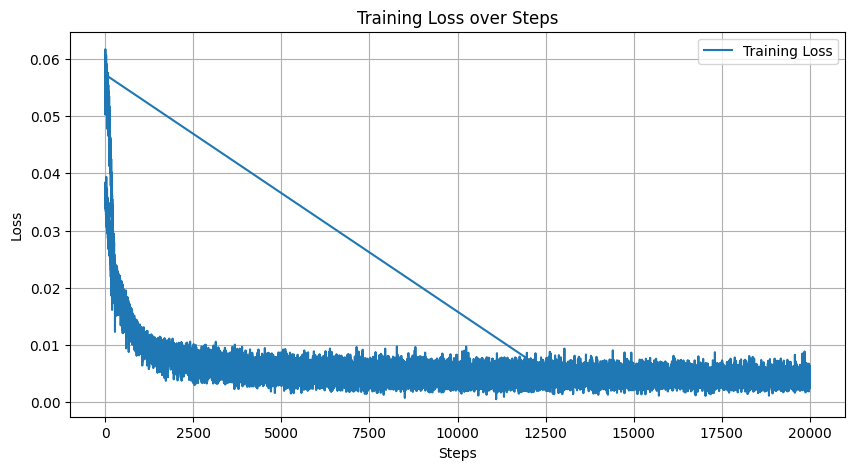

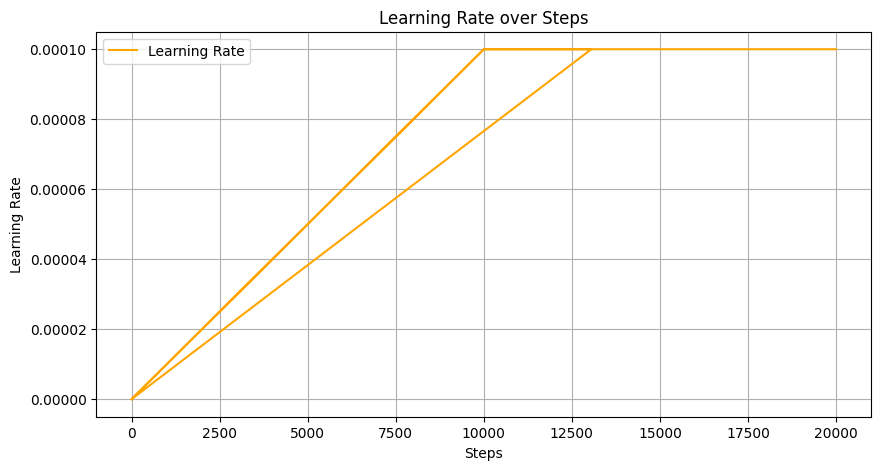

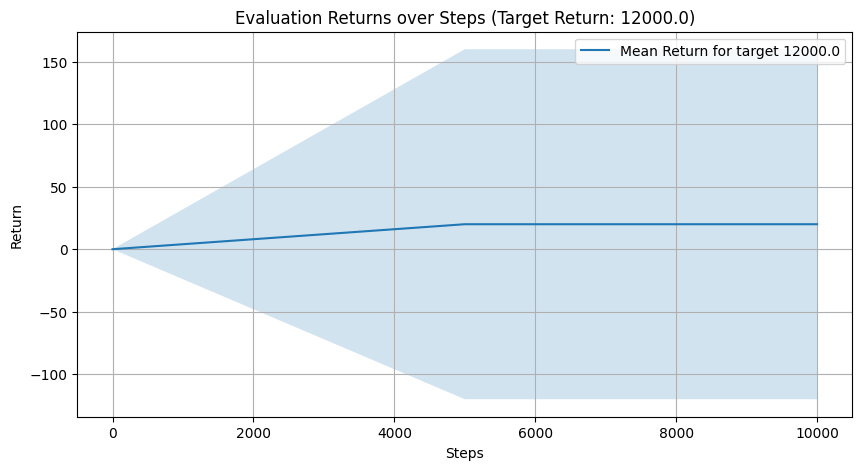

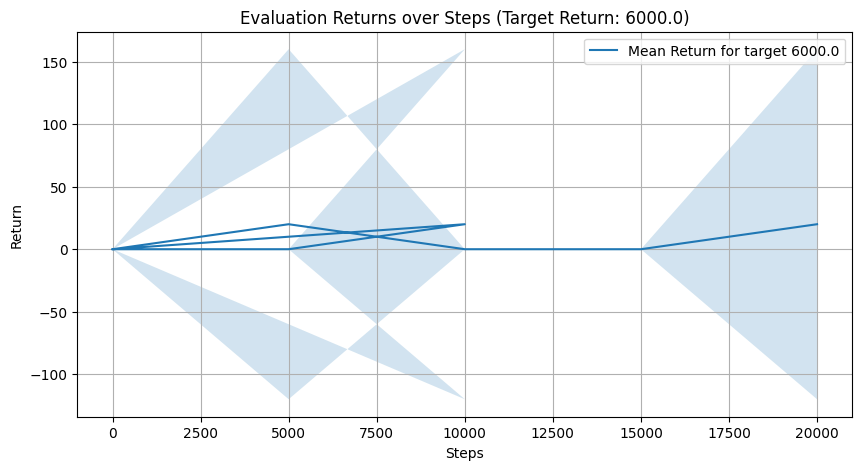

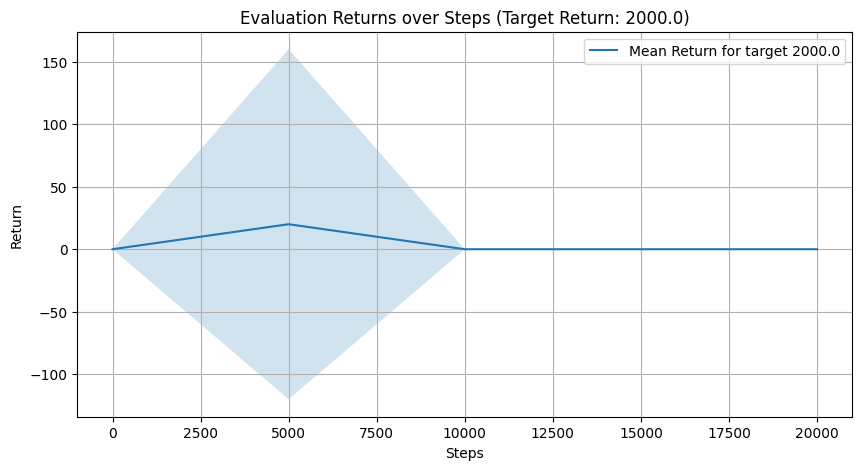

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the training results from the CSV file
train_results_df = pd.read_csv(train_results_file)
eval_results_df = pd.read_csv(eval_results_file)

# Plot Training Loss over Steps
plt.figure(figsize=(10, 5))
plt.plot(train_results_df['step'], train_results_df['train_loss'], label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss over Steps')
plt.legend()
plt.grid(True)
plt.show()

# Plot Learning Rate over Steps
plt.figure(figsize=(10, 5))
plt.plot(train_results_df['step'], train_results_df['learning_rate'], label='Learning Rate', color='orange')
plt.xlabel('Steps')
plt.ylabel('Learning Rate')
plt.title('Learning Rate over Steps')
plt.legend()
plt.grid(True)
plt.show()

# Plot Evaluation Returns over Steps for each target return
for target_return in eval_results_df['target_return'].unique():
    subset = eval_results_df[eval_results_df['target_return'] == target_return]
    plt.figure(figsize=(10, 5))
    plt.plot(subset['step'], subset['eval_return_mean'], label=f'Mean Return for target {target_return}')
    plt.fill_between(subset['step'], subset['eval_return_mean'] - subset['eval_return_std'], subset['eval_return_mean'] + subset['eval_return_std'], alpha=0.2)
    plt.xlabel('Steps')
    plt.ylabel('Return')
    plt.title(f'Evaluation Returns over Steps (Target Return: {target_return})')
    plt.legend()
    plt.grid(True)
    plt.show()


#### run process (tasks set consists of different start positions and fixed goal positions, considering that there are only 81 positions, tasks set probably has the repeated tasks)

## Part 3. Autoregressive Evaluation

- what should we pass to the transformer, originally in our code we get:
predicted_actions = model(
            states=states,
            actions=actions,
            returns_to_go=returns,
            time_steps=time_steps,
            padding_mask=padding_mask,
        )
      

- Transformer populates its own context,  where the context queue is supposed to be limited to the seq_len that was used to train transformer.
-

In [ ]:
def autoregressive_evaluation(model, # transformer
                              test_task_set,
                              num_seeds=10,  # to see different results ???
                              n_episodes=1000,
                              max_episode_length=1000 # was 200 for the DQN, so should we change it?
                              ):
    """
    Evaluates the performance of the distilled model on unseen tasks using autoregressive evaluation.

    Parameters:
    - model: The trained transformer model to be evaluated.
    - test_task_set: A set of test tasks to sample from.
    - num_seeds: Number of random seeds for evaluation (i.e., how many times the evaluation process is repeated).
    - max_episode_length: Maximum length of an episode.

    Returns:
    - results: A list of returns (sum of rewards) for each seed.
    """

    results = []

    for k in range(num_seeds):
        # Step 1: Sample a test task
        test_task_ind = np.random.choice(test_task_set)

        # env = test_task.get_env()  # Assuming each test_task has a method to get the environment


        context_queue = deque(maxlen=config.seq_len)
        total_return = 0

        # Reset the environment and get the initial state
        # state = env.reset()
        state = env.reset_from_set(env.pos_to_state(test_task_set[test_task_ind]))
        # just use eval_rollout
        for _ in range(max_episode_length):
            if len(context_queue) > 0:
                # Extract relevant information from the context queue
                states, actions, rewards, returns = zip(*context_queue)
                # Convert these into tensors or whatever format your model requires
                input_data = pass #(states, actions, rewards, returns)
            else:
                input_data = pass #([state], [], [], [])


            actions_distr = model.predict(input_data)  # Adjust according to your model's API
            action = pass
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            context_queue.append((state, action, reward, total_return))

            # Accumulate the return
            total_return += reward

            # Move to the next state
            state = next_state

            if done:
                break

        # Store the total return for this seed
        results.append(total_return)

    return results


## Other implementations

According to the article, LSTM ... .


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTM(nn.Module):
    def __init__(self, obs_dim, action_dim, embedding_dim, lstm_hidden_size=512, mlp_depth=2, mlp_width=256):
        super(LSTM, self).__init__()

        self.obs_embedding = nn.Linear(obs_dim, embedding_dim)
        self.action_embedding = nn.Linear(action_dim, embedding_dim)
        self.reward_embedding = nn.Linear(1, embedding_dim)

        self.lstm = nn.LSTM(input_size=3*embedding_dim, hidden_size=lstm_hidden_size, batch_first=True)

        mlp_layers = []
        input_size = lstm_hidden_size + embedding_dim  # LSTM output + current observation embedding
        for _ in range(mlp_depth):
            mlp_layers.append(nn.Linear(input_size, mlp_width))
            mlp_layers.append(nn.ReLU())
            input_size = mlp_width
        mlp_layers.append(nn.Linear(mlp_width, action_dim))

        self.mlp = nn.Sequential(*mlp_layers)

    def forward(self, observations, actions, rewards, current_observation):
        # observations - states?
        #
        batch_size, seq_len = observations.size(0), observations.size(1)

        # Embedding layers
        obs_embeds = self.obs_embedding(observations)  # [batch_size, seq_len, embedding_dim]
        action_embeds = self.action_embedding(actions)  # [batch_size, seq_len, embedding_dim]
        reward_embeds = self.reward_embedding(rewards.unsqueeze(-1))  # [batch_size, seq_len, embedding_dim]

        # Concatenate embeddings
        lstm_input = torch.cat((obs_embeds, action_embeds, reward_embeds), dim=-1)  # [batch_size, seq_len, 3*embedding_dim]

        # LSTM processing
        lstm_output, _ = self.lstm(lstm_input)  # lstm_output: [batch_size, seq_len, lstm_hidden_size]

        # Take the output of the last time step
        lstm_output_last = lstm_output[:, -1, :]  # [batch_size, lstm_hidden_size]

        # Embed the current observation
        current_obs_embed = self.obs_embedding(current_observation)  # [batch_size, embedding_dim]

        # Concatenate LSTM output with the current observation embedding
        combined = torch.cat((lstm_output_last, current_obs_embed), dim=-1)  # [batch_size, lstm_hidden_size + embedding_dim]

        # Pass through MLP
        action_distribution = self.mlp(combined)  # [batch_size, action_dim]

        return action_distribution

# Example usage
obs_dim = 10  # Example observation dimension
action_dim = 4  # Example action dimension
embedding_dim = 32  # Example embedding dimension

model = LSTM(obs_dim, action_dim, embedding_dim)

# Example data
observations = torch.randn(32, 5, obs_dim)  # [batch_size, seq_len, obs_dim]
actions = torch.randint(0, action_dim, (32, 5))  # [batch_size, seq_len]
rewards = torch.randn(32, 5)  # [batch_size, seq_len]
current_observation = torch.randn(32, obs_dim)  # [batch_size, obs_dim]

# Forward pass
action_distribution = model(observations, actions, rewards, current_observation)
print(action_distribution.shape)  # [batch_size, action_dim]




In [ ]:
torch.nn.NLLLoss

### checking 3d party DQN algo [pytorch]

In [ ]:
MAX_STEP=150

env = DarkRoom(size = 9, goal=None, random_start=False, terminate_on_goal=True, max_steps=MAX_STEP)
print(env.action_space, env.observation_space)
s, _  = env.reset()
overall_task_set = env.generate_tasks(1000)
train_tasks, test_tasks = split_tasks(overall_task_set)
hidden_dims = (128, 256, 512, 512, 256, 128)

Discrete(5) Discrete(81)


In [ ]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from IPython import display

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        # print("FORWARD: x ", x.shape)
        x = F.relu(self.layer1(x))
        # print("FORWARD: x ", x.shape)
        x = F.relu(self.layer2(x))
        # print("FORWARD: x ", x.shape)
        return self.layer3(x)

In [ ]:
print(env.reset())

(40, {})


In [ ]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = 1 # env.observation_space.n
print("n_actions: ", n_actions, " n_observations ", n_observations)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0

def select_action_eps_greedy(Q, state, epsilon):
    """ Changed how the states is passed to it, and added the to_tensor method."""
    if not isinstance(state, torch.Tensor):
        # state = torch.tensor(state, dtype=torch.float32)
        state = to_tensor(state)

    #  with torch.no_grad():

    Q_s = Q(state).detach().numpy()
    if np.random.random() < epsilon:
      n_actions = Q_s.shape[-1]
      action = np.random.choice(n_actions)
    else:
      action = np.argmax(Q_s)

    action = int(action)
    return action

episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    is_ipython = True
    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

n_actions:  5  n_observations  1


In [ ]:
import matplotlib.pyplot as plt

monitoring = {
    'steps': [],
    'update_target_steps': [],
    'regularizers': [],
    'lrs':[],
    'epsilons':[],
    'total_max_steps':[],
    'total_rewards': [],   # List of lists for each training
    'losses': []           # List of lists for each training
}

In [ ]:
def optimize_model():
    global monitoring
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # for i in transitions:
    #   print(i)

    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))
    # print("batch", batch)
    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_batch = state_batch.view(-1, 1)
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    non_final_next_states = non_final_next_states.view(-1, 1)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    monitoring['loss'].append(loss)
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [ ]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            pn = policy_net(state)
            pn2 = pn.max(0)
            pn3 = pn2.indices

            return pn3.view(1,1)#policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


In [ ]:
expand = torch.tensor(np.zeros(128))
expand.view(128, 1).shape

torch.Size([128, 1])

Complete


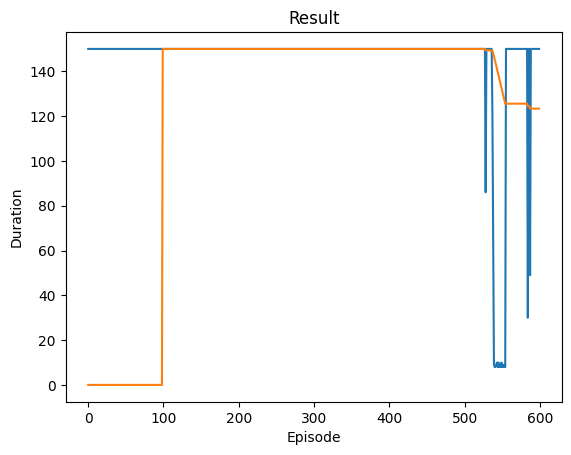

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    print(f"Env.start_pos {env.start_pos} and the goal position {env.goal_pos} on episode {i_episode}")
    print(env.goal_pos)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    total_reward = 0
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item()) # return self.pos_to_state(self.agent_pos), reward, terminated, truncated, {}
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        total_reward += reward
        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()


        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            if terminated:
                print("SOLVED")
            episode_durations.append(t + 1)
            plot_durations()
            break

    monitoring['total_reward'].append(total_reward)
print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [ ]:
policy_net

### 3d party DQN [github, mazesolver]

Got from https://github.com/giorgionicoletti/deep_Q_learning_maze/blob/master/deep_qlearning.ipynb

In [ ]:
import numpy as np
import scipy.special as sp

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import copy
import time
import random

import torch
import torch.nn as nn
import torch.optim as optim
import collections

In [ ]:
Transition = collections.namedtuple('Experience',
                                    field_names=['state', 'action',
                                                 'next_state', 'reward',
                                                 'is_game_on'])

class ExperienceReplay:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.memory)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size, device = 'cuda'):
        indices = np.random.choice(len(self.memory), batch_size, replace = False)

        states, actions, next_states, rewards, isgameon = zip(*[self.memory[idx]
                                                                for idx in indices])

        return torch.Tensor(states).type(torch.float).to(device), \
               torch.Tensor(actions).type(torch.long).to(device), \
               torch.Tensor(next_states).to(device), \
               torch.Tensor(rewards).to(device), torch.tensor(isgameon).to(device)

In [ ]:
# Network definitions:

class fc_nn(nn.Module):
    def __init__(self, Ni, Nh1, Nh2, No = 4):
        super().__init__()

        self.fc1 = nn.Linear(Ni, Nh1)
        self.fc2 = nn.Linear(Nh1, Nh2)
        self.fc3 = nn.Linear(Nh2, No)

        self.act = nn.ReLU()

    def forward(self, x, classification = False, additional_out=False):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        out = self.fc3(x)

        return out

class conv_nn(nn.Module):

    channels = [16, 32, 64]
    kernels = [3, 3, 3]
    strides = [1, 1, 1]
    in_channels = 1

    def __init__(self, rows, cols, n_act):
        super().__init__()
        self.rows = rows
        self.cols = cols

        self.conv = nn.Sequential(nn.Conv2d(in_channels = self.in_channels,
                                            out_channels = self.channels[0],
                                            kernel_size = self.kernels[0],
                                            stride = self.strides[0]),
                                  nn.ReLU(),
                                  nn.Conv2d(in_channels = self.channels[0],
                                            out_channels = self.channels[1],
                                            kernel_size = self.kernels[1],
                                            stride = self.strides[1]),
                                  nn.ReLU()
                                 )

        size_out_conv = self.get_conv_size(rows, cols)

        self.linear = nn.Sequential(nn.Linear(size_out_conv, rows*cols*2),
                                    nn.ReLU(),
                                    nn.Linear(rows*cols*2, int(rows*cols/2)),
                                    nn.ReLU(),
                                    nn.Linear(int(rows*cols/2), n_act),
                                   )

    def forward(self, x):
        x = x.view(len(x), self.in_channels, self.rows, self.cols)
        out_conv = self.conv(x).view(len(x),-1)
        out_lin = self.linear(out_conv)
        return out_lin

    def get_conv_size(self, x, y):
        out_conv = self.conv(torch.zeros(1,self.in_channels, x, y))
        return int(np.prod(out_conv.size()))

In [ ]:
def Qloss(batch, net, gamma=0.99, device="cuda"):
    states, actions, next_states, rewards, _ = batch
    lbatch = len(states)
    state_action_values = net(states.view(lbatch,-1))
    state_action_values = state_action_values.gather(1, actions.unsqueeze(-1))
    state_action_values = state_action_values.squeeze(-1)

    next_state_values = net(next_states.view(lbatch, -1))
    next_state_values = next_state_values.max(1)[0]

    next_state_values = next_state_values.detach()
    expected_state_action_values = next_state_values * gamma + rewards

    return nn.MSELoss()(state_action_values, expected_state_action_values)